In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
start = []
import networkx as nx
import graphviz
#import pygraphviz as pgv
from networkx.drawing.nx_agraph import graphviz_layout

In [39]:
if not start:
    path = '/Users/aymericvie/Documents/GitHub/evology/evology/data/replication/empirical_funds/flow_data.csv'
    df = pd.read_csv(path)
    df["Sum_redemptions"] = df['month_1_flow_redemption'] + df['month_2_flow_redemption'] + df['month_3_flow_redemption']
    df["Red_flows_nav"] = 100 * (df["Sum_redemptions"]) / df["net_assets"]
    arr = [np.nan]
    for i in range(len(df)):
        if i > 1:
            if df["series_id"].iloc[i] == df["series_id"].iloc[i-1]:
                arr.append((df["net_assets"].iloc[i] - df["Sum_redemptions"].iloc[i]) / df["net_assets"].iloc[i-1] - 1)
            else:
                arr.append(np.nan)
    arr.append(np.nan)
    df["nav_diff"] = arr
    df = df[(df["nav_diff"] <= 1.0) &  (df["nav_diff"] >= -1.0)]
    df = df[abs(df["Red_flows_nav"]) <= 25]
    df2 = pd.DataFrame()
    df2["nav_diff"] = df["nav_diff"]
    df2["Sum_redemptions"] = df["Sum_redemptions"]
    df2["Red_flows_nav"] = df["Red_flows_nav"]

    df3 = df2[(df2["nav_diff"] <= 0.4) & (df2["nav_diff"] >= -0.4)]
    df3 = df3[(df["Sum_redemptions"] < df["Sum_redemptions"].quantile(q=0.9)) & (df["Sum_redemptions"] > df["Sum_redemptions"].quantile(q=0.1))]
start = [1]

/var/folders/vt/cnvcr__n5pn60jkl8nh7fzrw0000gn/T/ipykernel_20226/1030071459.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = df3[(df["Sum_redemptions"] < df["Sum_redemptions"].quantile(q=0.9)) & (df["Sum_redemptions"] > df["Sum_redemptions"].quantile(q=0.1))]


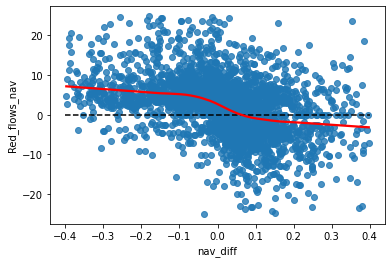

In [40]:
sns.regplot(x="nav_diff", y="Red_flows_nav", lowess=True,data=df3, line_kws={"color": "red"})
plt.hlines(y=0, colors='black', linestyles='dashed',xmin = -0.4, xmax = 0.4)
plt.show()

In [41]:
import operator
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [42]:
# Define new functions
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
# pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
pset.renameArguments(ARG0='x')

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [43]:
def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    sqerrors = ((func(x) - x**4 - x**3 - x**2 - x)**2 for x in points)
    return math.fsum(sqerrors) / len(points),

toolbox.register("evaluate", evalSymbReg, points=[x/10. for x in range(-10,10)])
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))


In [44]:
def main():
    random.seed(318)

    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)

    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", numpy.mean)
    mstats.register("std", numpy.std)
    mstats.register("min", numpy.min)
    mstats.register("max", numpy.max)

    pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 40, stats=mstats,
                                   halloffame=hof, verbose=True)
    # print log
    return pop, log, hof

In [45]:
if __name__ == "__main__":
    pop, log, hof = main()

print(hof)

   	      	                        fitness                        	                      size                     
   	      	-------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max   	min     	nevals	std    	avg 	gen	max	min	nevals	std    
0  	300   	1.60244	0  	58.207	0.165572	300   	3.60241	3.79	0  	7  	2  	300   	1.55753
1  	173   	0.860221	1  	4.19956	0.16385 	173   	0.508196	3.89667	1  	12 	1  	173   	1.86886
2  	166   	0.695606	2  	4.19956	0.0873516	166   	0.402044	3.61333	2  	13 	1  	166   	1.89662
3  	172   	0.688237	3  	2.92357	0.0873516	172   	0.443239	3.72333	3  	14 	1  	172   	2.3594 
4  	152   	0.606938	4  	6.36889	0.0873516	152   	0.500792	4.28667	4  	14 	1  	152   	2.52279
5  	174   	0.599495	5  	4.20158	0.0873516	174   	0.532567	5.52333	5  	16 	1  	174   	2.81356
6  	166   	0.468928	6  	2.3179 	0.0873516	166   	0.338428	6.03667	6  	16 	1  	166   	2.73898
7  	171   	0.500839	7  	15.8973	0.0873516

In [46]:
bests = tools.selBest(pop, k=1)

nodes, edges, labels = gp.graph(bests[0])
graph = nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
pos = graphviz_layout(graph, prog="dot")  # run dot -c in conda prompt
plt.figure(figsize=(7, 7))
nx.draw_networkx_nodes(graph, pos, node_size=900, node_color="w")
nx.draw_networkx_edges(graph, pos)
nx.draw_networkx_labels(graph, pos, labels)
plt.axis("off")
plt.show()


def plot_graph(tree):
    nodes, edges, labels = gp.graph(tree)
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    pos = graphviz_layout(graph, prog="dot")  # run dot -c in conda prompt
    plt.figure(figsize=(7, 7))
    nx.draw_networkx_nodes(graph, pos, node_size=900, node_color="w")
    nx.draw_networkx_edges(graph, pos)
    nx.draw_networkx_labels(graph, pos, labels)
    plt.axis("off")
    plt.show()


# print("Pop")
# for i in range(len(pop)):
#     print(pop[i])
#     plot_graph(pop[i])

print("Best ")
print(bests[0])

ImportError: requires pygraphviz http://pygraphviz.github.io/